In [30]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
import joblib
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier, DMatrix, cv
from sklearn.model_selection import train_test_split
from itertools import combinations
from sklearn.model_selection import ParameterGrid

## Load Data

In [31]:
train_clean = joblib.load('data/train_clean.pckl')
test_clean = joblib.load('data/test_clean.pckl')

X_tfidf = joblib.load('data/X_tfidf.pckl')
X_svd = joblib.load('data/X_svd.pckl')

X_test_tfidf = joblib.load('data/X_test_tfidf.pckl')
X_test_svd = joblib.load('data/X_test_svd.pckl')

In [32]:
# Create data set to hold CV predictions on training data for stacked model fit

stack_train = train_clean[['id','toxic','severe_toxic','obscene','threat','insult','identity_hate']].copy()

## Create Folds to Use Across Methods

In [33]:
skf = StratifiedKFold(n_splits=10, random_state=678246569, shuffle=True)

## Naive Bayes

In [34]:
model = 'NB'
mbayes = MultinomialNB()

for target in ['toxic','severe_toxic','obscene','threat','insult','identity_hate']:

    stack_train[model+'_'+target] = np.nan

    for train, test in skf.split(X_tfidf, train_clean[target]):
        mbayes.fit(X_tfidf[train, :], train_clean.loc[train, target])
        preds = mbayes.predict_proba(X_tfidf[test, :])
        stack_train.loc[test, model+'_'+target] = preds[:,1]

In [35]:
stack_train.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,NB_toxic,NB_severe_toxic,NB_obscene,NB_threat,NB_insult,NB_identity_hate
0,0000997932d777bf,0,0,0,0,0,0,0.000072,1.523027e-07,0.000008,2.718901e-08,0.000008,1.345856e-07
1,000103f0d9cfb60f,0,0,0,0,0,0,0.000916,1.319286e-05,0.000212,2.449853e-06,0.000157,9.285133e-06
2,000113f07ec002fd,0,0,0,0,0,0,0.000098,5.031757e-08,0.000009,5.857017e-09,0.000006,4.529827e-08
3,0001b41b1c6bb37e,0,0,0,0,0,0,0.000012,2.935742e-08,0.000002,5.856117e-09,0.000002,3.401068e-08
4,0001d958c54c6e35,0,0,0,0,0,0,0.015519,2.742424e-04,0.005280,7.348771e-05,0.004632,2.977539e-04


## Regularized Logistic Regression

In [36]:
model = 'LOG'

final_c = {'toxic':20,
           'severe_toxic':2,
           'obscene':9,
           'threat':11,
           'insult':7,
           'identity_hate':9}

for target in ['toxic','severe_toxic','obscene','threat','insult','identity_hate']:
    
    stack_train[model+'_'+target] = np.nan

    for train, test in skf.split(X_tfidf, train_clean[target]):
        log = LogisticRegression(C=final_c[target]).fit(X_tfidf[train,:], train_clean.loc[train, target])
        preds = log.predict_proba(X_tfidf[test, :])
        stack_train.loc[test, model+'_'+target] = preds[:,1]

In [37]:
stack_train.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,NB_toxic,NB_severe_toxic,NB_obscene,NB_threat,NB_insult,NB_identity_hate,LOG_toxic,LOG_severe_toxic,LOG_obscene,LOG_threat,LOG_insult,LOG_identity_hate
0,0000997932d777bf,0,0,0,0,0,0,0.000072,1.523027e-07,0.000008,2.718901e-08,0.000008,1.345856e-07,0.002438,0.002235,0.001533,0.000273,0.002588,0.000460
1,000103f0d9cfb60f,0,0,0,0,0,0,0.000916,1.319286e-05,0.000212,2.449853e-06,0.000157,9.285133e-06,0.005042,0.003524,0.003219,0.000489,0.002749,0.000847
2,000113f07ec002fd,0,0,0,0,0,0,0.000098,5.031757e-08,0.000009,5.857017e-09,0.000006,4.529827e-08,0.011013,0.001905,0.012241,0.000242,0.010170,0.000503
3,0001b41b1c6bb37e,0,0,0,0,0,0,0.000012,2.935742e-08,0.000002,5.856117e-09,0.000002,3.401068e-08,0.000254,0.001223,0.001186,0.000191,0.000908,0.000395
4,0001d958c54c6e35,0,0,0,0,0,0,0.015519,2.742424e-04,0.005280,7.348771e-05,0.004632,2.977539e-04,0.006478,0.004399,0.014154,0.000831,0.018076,0.002973


## LDA w/ SVD Decomp

In [38]:
model = 'LDA'

final_shrinkage = {'toxic': .4,
                   'severe_toxic': .8,
                   'obscene': .5,
                   'threat': .8,
                   'insult': .5,
                   'identity_hate': .7}

for target in ['toxic','severe_toxic','obscene','threat','insult','identity_hate']:

    stack_train[model+'_'+target] = np.nan

    for train, test in skf.split(X_tfidf, train_clean[target]):
        lda = LinearDiscriminantAnalysis(shrinkage=final_shrinkage[target], solver='eigen')
        lda.fit(X_svd[train, :], train_clean.loc[train, target])
        preds = lda.predict_proba(X_svd[test, :])
        stack_train.loc[test, model+'_'+target] = preds[:,1]

In [39]:
stack_train.head().transpose()

,0,1,2,3,4
id,0000997932d777bf,000103f0d9cfb60f,000113f07ec002fd,0001b41b1c6bb37e,0001d958c54c6e35
toxic,0,0,0,0,0
severe_toxic,0,0,0,0,0
obscene,0,0,0,0,0
threat,0,0,0,0,0
insult,0,0,0,0,0
identity_hate,0,0,0,0,0
NB_toxic,7.18358e-05,0.000915659,9.83415e-05,1.20258e-05,0.0155186
NB_severe_toxic,1.52303e-07,1.31929e-05,5.03176e-08,2.93574e-08,0.000274242
NB_obscene,7.73267e-06,0.000211522,8.72534e-06,2.0504e-06,0.00527961


In [40]:
joblib.dump(stack_train, 'data/stacking_train.pckl')

['data/stacking_train.pckl']

## Process and Store Stacking Data

In [21]:
# create target level X df's with standardized features, and saved scaler transformers

x_dfs = dict()
m_list = ['NB_', 'LOG_', 'LDA_']

for target in ['toxic','severe_toxic','obscene','threat','insult','identity_hate']:
    X = stack_train[[item+target for item in m_list]]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    x_dfs[target] = scaler, X_scaled

In [24]:
# process test data (base model scores) for scoring stacked models

s1 = pd.read_csv('data/S1_baselineNB.csv')
s3 = pd.read_csv('data/S3_lda_svd.csv')
s4 = pd.read_csv('data/S4_logistic_tuned.csv')

x_dfs_test = dict()

for target in ['toxic','severe_toxic','obscene','threat','insult','identity_hate']:
    X = pd.concat([s1[target], s4[target], s3[target]], axis=1)
    X.columns = ['NB_'+target, 'LOG_'+target, 'LDA_'+target]
    scaler = x_dfs[target][0]
    x_dfs_test[target] = scaler.transform(X)

In [100]:
# check scaled dist's

for target in ['toxic','severe_toxic','obscene','threat','insult','identity_hate']:
    x = x_dfs[target][1]
    print(target.upper())
    print(x.mean(axis=0).round(5))
    print(x.min(axis=0).round(5))
    print(x.max(axis=0).round(5))
    print(x.std(axis=0).round(5))

TOXIC
[-0.  0.  0.]
[-0.22589 -0.35046 -2.65549]
[ 14.19334   4.08068  21.15087]
[ 1.  1.  1.]
SEVERE_TOXIC
[ 0. -0. -0.]
[-0.20947 -0.18233 -1.77888]
[ 112.50881   19.49309   29.87738]
[ 1.  1.  1.]
OBSCENE
[-0. -0.  0.]
[-0.15203 -0.2615  -1.93652]
[ 25.06109   5.48827  26.91195]
[ 1.  1.  1.]
THREAT
[ 0. -0. -0.]
[-0.14649 -0.08855 -4.01239]
[ 220.02669   48.28798   17.83273]
[ 1.  1.  1.]
INSULT
[-0. -0.  0.]
[-0.17959 -0.2806  -2.23749]
[ 39.18552   6.42271  24.55934]
[ 1.  1.  1.]
IDENTITY_HATE
[ 0.  0.  0.]
[-0.20797 -0.1413  -3.45602]
[ 114.82021   22.89335   21.67343]
[ 1.  1.  1.]


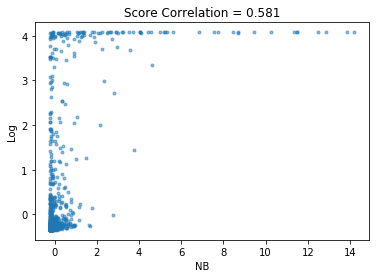

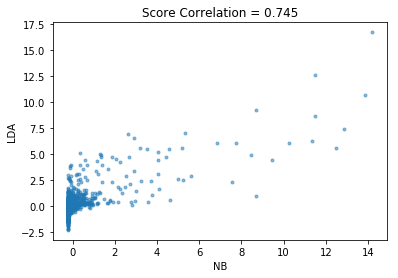

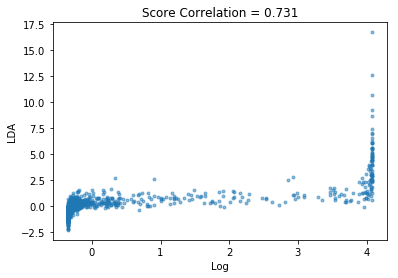

In [57]:
# look at score correlation - distributions and corrs are ugly ... may not stack well?

sampsize = 2000

temp = pd.DataFrame(x_dfs['toxic'][1]).sample(sampsize, axis=0)
temp.columns=['NB','Log','LDA']

for comb in combinations(temp.columns, 2):
    corr = np.corrcoef(temp[comb[0]], temp[comb[1]])

    plt.plot(temp[comb[0]], temp[comb[1]], '.', alpha=.5)
    plt.title('Score Correlation = %0.3f' % corr[0,1])
    plt.axis('tight')
    plt.xlabel(comb[0])
    plt.ylabel(comb[1])
    plt.show()

In [5]:
# joblib.dump(x_dfs, 'data/stacking_train_xdfs.pckl')
# joblib.dump(x_dfs_test, 'data/stacking_test_xdfs.pckl')

x_dfs = joblib.load('data/stacking_train_xdfs.pckl')
x_dfs_test = joblib.load('data/stacking_test_xdfs.pckl')

## Stacking

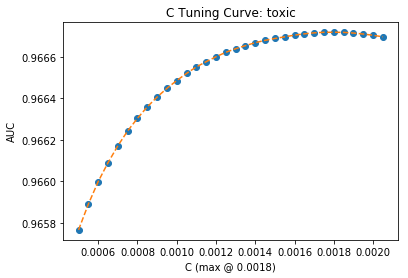

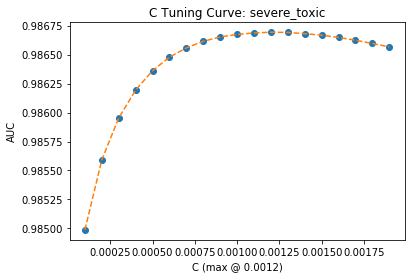

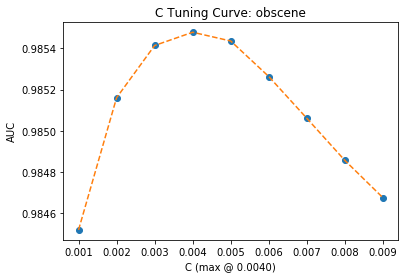

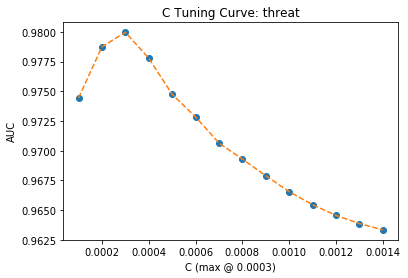

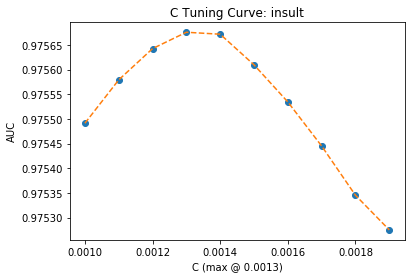

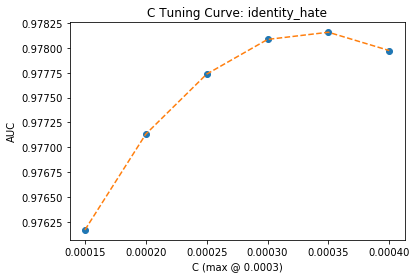

In [121]:
# tune C params for regularized logistic stacked model

for target in ['toxic','severe_toxic','obscene','threat','insult','identity_hate']:
    
    stack = LogisticRegression(fit_intercept=False)

    params = {'toxic'           : {'C': np.arange(.0005,.0021,.00005)},
              'severe_toxic'    : {'C': np.arange(.0001,.002,.0001)},
              'obscene'         : {'C': np.arange(.001,.01,.001)},
              'threat'          : {'C': np.arange(.0001,.0015,.0001)},
              'insult'          : {'C': np.arange(.001,.002,.0001)},
              'identity_hate'   : {'C': np.arange(.00015,.00045,.00005)}}

    estimator = GridSearchCV(stack, 
                            params[target],
                            scoring='roc_auc',
                            n_jobs=3,
                            cv=StratifiedKFold(5))

    estimator.fit(x_dfs[target][1], stack_train[target])

    x = np.ma.getdata(estimator.cv_results_['param_C']).astype(np.float)
    y = estimator.cv_results_['mean_test_score']
    plt.plot(x, y, 'o', x, y , '--')
    plt.title('C Tuning Curve: '+target)
    plt.axis('tight')
    plt.xlabel('C (max @ %0.4f)' % x[np.argmax(y)])
    plt.ylabel('AUC')
    plt.show()

In [82]:
# Check Stacked CV Performance - doesn't seem it's going to add much value (maybe even detract)

final_c = {'toxic':          0.0018,
           'severe_toxic':   0.0012,
           'obscene':        0.0040,
           'threat':         0.0003,
           'insult':         0.0013,
           'identity_hate':  0.0003}

for target in ['toxic','severe_toxic','obscene','threat','insult','identity_hate']:

    X = stack_train[['NB_'+target, 'LOG_'+target, 'LDA_'+target]]

    print(target.upper())
    print()
    
    for train, test in skf.split(X, train_clean[target]):

        stack = LogisticRegression(C=final_c[target])
        stack.fit(X.loc[train], stack_train.loc[train, target])
        scores = stack.predict_proba(X.loc[test])[:,1]
        
        fpr, tpr, thresholds = roc_curve(stack_train.loc[test, target], scores, pos_label=1)
        roc_auc_stack = auc(fpr, tpr)
        
        fpr, tpr, thresholds = roc_curve(stack_train.loc[test, target], stack_train.loc[test, 'LOG_'+target], pos_label=1)
        roc_auc_log = auc(fpr, tpr)
        
        fpr, tpr, thresholds = roc_curve(stack_train.loc[test, target], stack_train.loc[test, 'LDA_'+target], pos_label=1)
        roc_auc_lda = auc(fpr, tpr)
        
        fpr, tpr, thresholds = roc_curve(stack_train.loc[test, target], stack_train.loc[test, 'NB_'+target], pos_label=1)
        roc_auc_nb = auc(fpr, tpr)
        
        print(round(roc_auc_stack,4), round(roc_auc_log,4), round(roc_auc_lda,4), round(roc_auc_nb,4))
        
    print()

TOXIC

0.9702 0.9702 0.921 0.8472
0.9734 0.9733 0.9238 0.8508
0.9728 0.9731 0.9267 0.8421
0.9758 0.9758 0.9312 0.8575
0.9727 0.9732 0.9259 0.8414
0.9761 0.9761 0.9287 0.8454
0.9716 0.9716 0.9213 0.8553
0.9715 0.9718 0.9284 0.8499
0.9734 0.9735 0.9324 0.8557
0.9732 0.9736 0.9264 0.8449

SEVERE_TOXIC

0.988 0.988 0.9858 0.8546
0.9861 0.9861 0.9796 0.8548
0.9861 0.9861 0.9836 0.8576
0.9862 0.9862 0.9807 0.8509
0.9882 0.9882 0.9797 0.8359
0.9882 0.9882 0.9796 0.8649
0.9897 0.9897 0.9835 0.8614
0.9833 0.9833 0.9787 0.8456
0.9881 0.9881 0.9805 0.8731
0.9839 0.9839 0.977 0.8762

OBSCENE

0.9877 0.9874 0.9654 0.8555
0.9892 0.989 0.9705 0.8636
0.9887 0.9883 0.9683 0.867
0.988 0.9879 0.9663 0.852
0.9873 0.9872 0.9718 0.8654
0.988 0.988 0.9646 0.8551
0.9876 0.9874 0.9637 0.8583
0.9861 0.9861 0.9651 0.8563
0.9855 0.9853 0.9635 0.8468
0.9891 0.9888 0.9667 0.8429

THREAT

0.989 0.989 0.937 0.7885
0.9888 0.9888 0.9191 0.7922
0.9827 0.9827 0.9045 0.6757
0.9874 0.9874 0.9122 0.7626
0.9867 0.9867 0.9291

In [134]:
# fit final stacked models on full training data (CV base model scores) and score on test data

final_c = {'toxic':          0.0018,
           'severe_toxic':   0.0012,
           'obscene':        0.0040,
           'threat':         0.0003,
           'insult':         0.0013,
           'identity_hate':  0.0003}

scores_stacked = s1[['id']].copy()

for target in ['toxic','severe_toxic','obscene','threat','insult','identity_hate']:
    
    stack = LogisticRegression(C=final_c[target],
                               fit_intercept=False)

    stack.fit(x_dfs[target][1], stack_train[target])
    
    scores_stacked[target] = stack.predict_proba(x_dfs_test[target])[:,1]
    
scores_stacked.to_csv('data/S5_stacked.csv', index=False)
scores_stacked.head(20)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,1.000000,0.921444,1.000000,0.660360,1.000000,0.995894
1,0000247867823ef7,0.153295,0.487513,0.143140,0.496954,0.292070,0.487509
2,00013b17ad220c46,0.425445,0.500779,0.355275,0.500622,0.464780,0.498553
3,00017563c3f7919a,0.134809,0.481433,0.134779,0.495891,0.278414,0.485173
4,00017695ad8997eb,0.187964,0.483287,0.161708,0.495963,0.316485,0.486661
5,0001ea8717f6de06,0.141222,0.479717,0.136563,0.495721,0.290865,0.485158
6,00024115d4cbde0f,0.133509,0.476589,0.132349,0.495037,0.275710,0.485066
7,000247e83dcc1211,0.999952,0.494858,0.326938,0.499094,0.727220,0.499328
8,00025358d4737918,0.142867,0.483310,0.150488,0.496718,0.298215,0.487798
9,00026d1092fe71cc,0.136683,0.480513,0.134008,0.495737,0.278778,0.485914


## xgboost Stacked Classifier

In [1]:
from sklearn.model_selection import ParameterGrid

In [85]:
# basic parameter tuning for xbgoost staking models

grid_results = list()

pgrid = ParameterGrid({'learning_rate': [.01],
                         'max_depth': [3,5,7],
                         'subsample': [.5,.7],
                         'min_child_weight': [5,10,20],
                         'objective': ['binary:logistic'], 
                         'booster': ['gbtree']})

for target in ['toxic','severe_toxic','obscene','threat','insult','identity_hate']:

    dtrain = DMatrix(x_dfs[target][1], train_clean[target])

    for p in pgrid:

        results = cv(p, 
               dtrain,
               num_boost_round=1000, 
               nfold=3, 
               stratified=True, 
               metrics=('auc'),
               early_stopping_rounds=100)
        
        p['auc'] = max(results['test-auc-mean'])
        p['ntrees'] = len(results)
        p['target'] = target
        
        grid_results.append(p)
        
joblib.dump(pd.DataFrame(grid_results), 'data/xgb_grid_results.pckl')

['data/xgb_grid_results.pckl']

In [86]:
res = pd.DataFrame(grid_results)
ids = res.groupby(['target'])['auc'].idxmax()
print(np.mean(res.loc[ids]['auc']))
res.loc[ids]

0.9823089444444445


,auc,booster,learning_rate,max_depth,min_child_weight,ntrees,objective,subsample,target
100,0.979801,gbtree,0.01,5,20,560,binary:logistic,0.5,identity_hate
72,0.979237,gbtree,0.01,3,5,603,binary:logistic,0.5,insult
37,0.988799,gbtree,0.01,3,5,1000,binary:logistic,0.7,obscene
19,0.987578,gbtree,0.01,3,5,682,binary:logistic,0.7,severe_toxic
58,0.984143,gbtree,0.01,3,20,632,binary:logistic,0.5,threat
6,0.974295,gbtree,0.01,5,5,497,binary:logistic,0.5,toxic


In [93]:
# tune size of trees for determined hyperparameters

final_params = res.loc[ids]

for target in ['toxic','severe_toxic','obscene','threat','insult','identity_hate']:

    dtrain = DMatrix(x_dfs[target][1], train_clean[target])

    p = {'learning_rate': .001,
         'max_depth': int(final_params.loc[final_params['target']==target, 'max_depth']),
         'subsample': float(final_params.loc[final_params['target']==target, 'subsample']),
         'min_child_weight': float(final_params.loc[final_params['target']==target, 'min_child_weight']),
         'objective': 'binary:logistic', 
         'booster': 'gbtree'}
            
    results = cv(p, 
           dtrain,
           num_boost_round=5000, 
           nfold=3, 
           stratified=True, 
           metrics=('auc'),
           early_stopping_rounds=100)

    print(target.upper(), len(results), max(results['test-auc-mean']))

TOXIC 1581 0.973739333333
SEVERE_TOXIC 397 0.979629333333
OBSCENE 1665 0.985291333333
THREAT 1236 0.963176333333
INSULT 3029 0.978540333333
IDENTITY_HATE 929 0.971654


In [99]:
# fit and score final xgb stacked models 

xgb_scores_stacked = test_clean[['id']].copy()

ntrees = {'toxic':1581,
          'severe_toxic':397,
          'obscene':1665,
          'threat':1236,
          'insult':3029,
          'identity_hate':929}

for target in ['toxic','severe_toxic','obscene','threat','insult','identity_hate']:

    m = XGBClassifier(n_estimators = ntrees[target],
             learning_rate =  .001,
             max_depth = int(final_params.loc[final_params['target']==target, 'max_depth']),
             subsample = float(final_params.loc[final_params['target']==target, 'subsample']),
             min_child_weight = float(final_params.loc[final_params['target']==target, 'min_child_weight']),
             objective = 'binary:logistic', 
             booster = 'gbtree')
        
    m.fit(x_dfs[target][1],train_clean[target])
    
    xgb_scores_stacked[target] = m.predict_proba(x_dfs_test[target])[:,1]
    
xgb_scores_stacked.to_csv('data/S7_stacked_xbg.csv', index=False)